<a href="https://colab.research.google.com/github/merazAfridi/Blood-Cell-Segmentation/blob/main/2_Unet%2B%2B_Blood_cell_segm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras


In [ ]:
import tensorflow as tf
import google.protobuf

print("TensorFlow version:", tf.__version__)
print("Protobuf version:", google.protobuf.__version__)


TensorFlow version: 1.15.0
Protobuf version: 3.19.0


In [ ]:
data_path = r'C:\Users\User\Final data'

In [ ]:
image_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
mask_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'

(1328, 128, 128, 3)
uint8


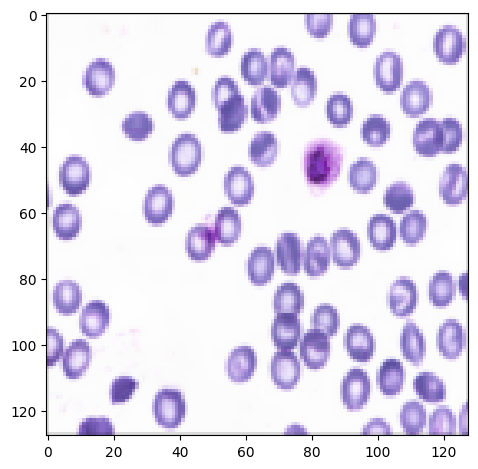

In [ ]:
#X train pure images from dataset
row = 128
columns = 128

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
training_images = os.listdir(train_data_path)
training_images.sort()


X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_images:
    path = os.path.join(image_data_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)

    X[index] = image
    index += 1

print(X.shape)

print(X.dtype)
imshow(X[0])

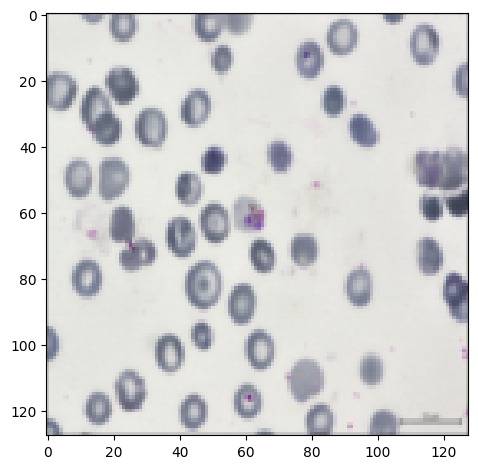

In [ ]:
imshow(X[10])

(1328, 128, 128, 3)
uint8


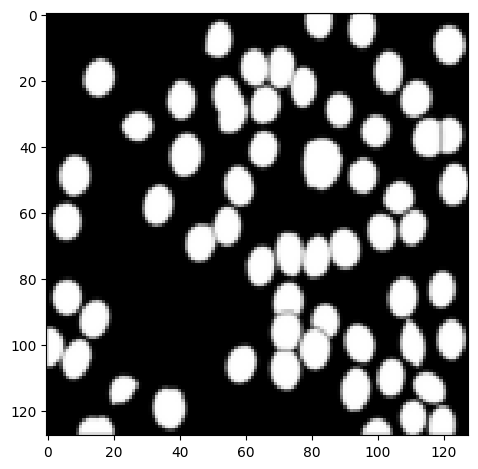

In [ ]:
## y train pure masks from dataset

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'
training_masks = os.listdir(train_data_path)
training_masks.sort()

y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_masks:
    path = os.path.join(mask_data_path, x)
#     print(path)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    #image.resize((128,128,1))
    y[index] = image
    index += 1

print(y.shape)
type(y)
print(y.dtype)
imshow(y[0])

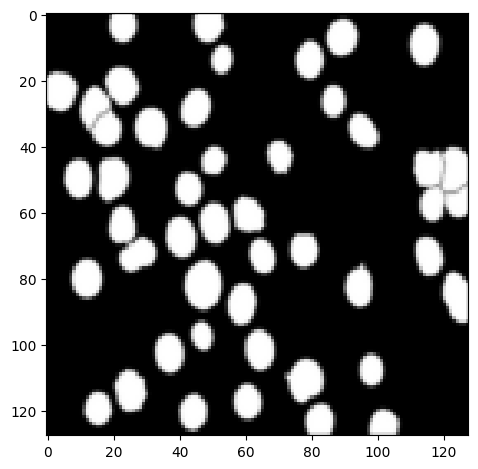

In [ ]:
imshow(y[10])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)


(1062, 128, 128, 3)
(1062, 128, 128, 3)

(266, 128, 128, 3)
(266, 128, 128, 3)


In [ ]:
def dice_coef(a, b):

    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [ ]:
#Libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose
# from keras.backend as K
import tensorflow.keras.backend as K
import tensorflow as tf


In [ ]:
# Import necessary libraries from TensorFlow's Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, add, multiply
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

In [ ]:
# Unet++

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Input, AvgPool2D
from tensorflow.keras.models import Model

dropout_rate = 0.5

#input_shape = (128, 128, 3), #n_labels    = 3

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(input_shape, n_labels, using_deep_supervision=True):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels last
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision==True:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.054,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

    opt = keras.optimizers.Adam(learning_rate=3e-4)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=[dice_coef, jaccard_index])
    #dice_coef, jaccard_index

    return model

In [ ]:
input_shape = (128,128,3)
n_labels = 3
model = model_build_func(input_shape, n_labels)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 128, 128, 32) 896         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 128, 128, 32) 512         conv2d_60[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 128, 128, 32) 0           batch_normalization_60[0][0]     
____________________________________________________________________________________________

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1062, 128, 128, 3)
(1062, 128, 128, 3)


In [ ]:
print(X_train.shape)
print(y_train.shape)

filepath = r"C:\Users\User\Blood Cell Seg ipybn\Unet++/cp.ckpt"

# Import necessary callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Early stopping to stop training when validation loss stops improving
earlystopper = EarlyStopping(patience=5, verbose=1)
# Model checkpoint to save the best model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Callback list including early stopping and checkpoint
callbacks_list = [checkpoint, earlystopper]
# Assuming deep supervision, y_train needs to be passed as a list of 4 outputs
y_train_multi = [y_train, y_train, y_train, y_train]

# Train the model
history = model.fit(X_train, y_train_multi, validation_split=0.1, batch_size=8, epochs=20, callbacks=callbacks_list)


(1062, 128, 128, 3)
(1062, 128, 128, 3)
Train on 955 samples, validate on 107 samples
Epoch 1/20
952/955 [============================>.] - ETA: 1s - loss: -1323.3927 - output_1_loss: -305.2088 - output_2_loss: -353.0917 - output_3_loss: -260.9269 - output_4_loss: -404.1653 - output_1_dice_coef: 1.8463 - output_1_jaccard_index: 17.5469 - output_2_dice_coef: 1.8074 - output_2_jaccard_index: 10.7147 - output_3_dice_coef: 1.8080 - output_3_jaccard_index: 12.3306 - output_4_dice_coef: 1.9007 - output_4_jaccard_index: 22.5995
Epoch 00001: val_loss improved from inf to -1190.99297, saving model to C:\Users\User\Blood Cell Seg ipybn\Unet++/cp.ckpt
955/955 [==============================] - 621s 650ms/sample - loss: -1325.5193 - output_1_loss: -306.6772 - output_2_loss: -354.5825 - output_3_loss: -262.0935 - output_4_loss: -405.6810 - output_1_dice_coef: 1.8465 - output_1_jaccard_index: 17.5314 - output_2_dice_coef: 1.8076 - output_2_jaccard_index: 10.7165 - output_3_dice_coef: 1.8083 - output

In [ ]:
print(X_train.shape)
print(y_train.shape)


(1062, 128, 128, 3)
(1062, 128, 128, 3)


In [ ]:
tf.keras.backend.print_tensor(
    history
)

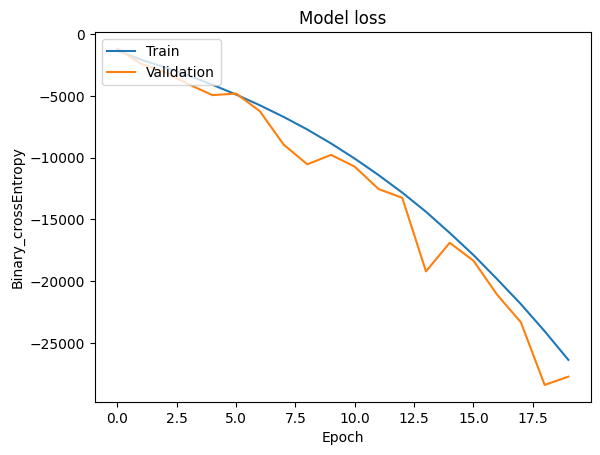

In [ ]:
#Plotting historyy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

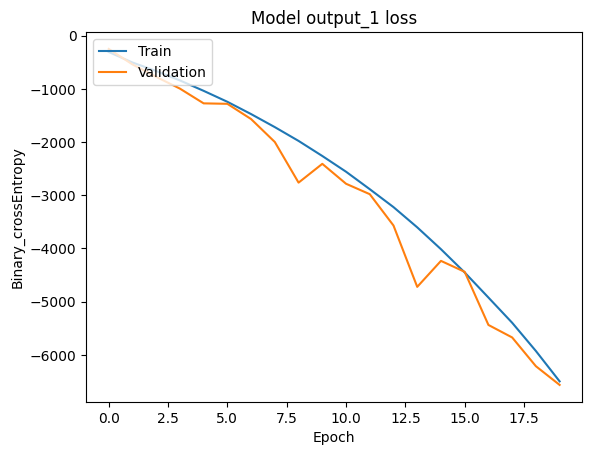

In [ ]:
plt.plot(history.history['output_1_loss'])
plt.plot(history.history['val_output_1_loss'])
plt.title('Model output_1 loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

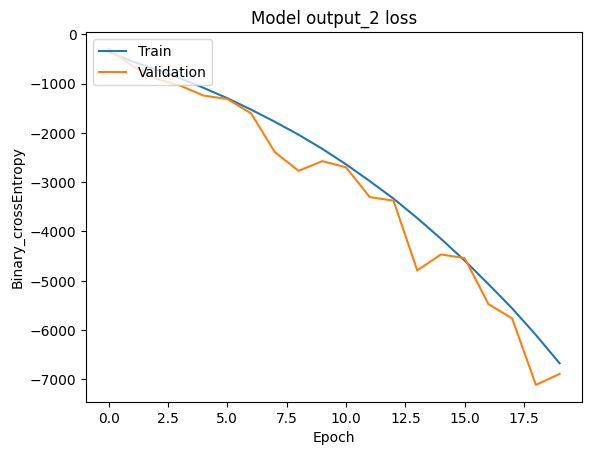

In [ ]:
plt.plot(history.history['output_2_loss'])
plt.plot(history.history['val_output_2_loss'])
plt.title('Model output_2 loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

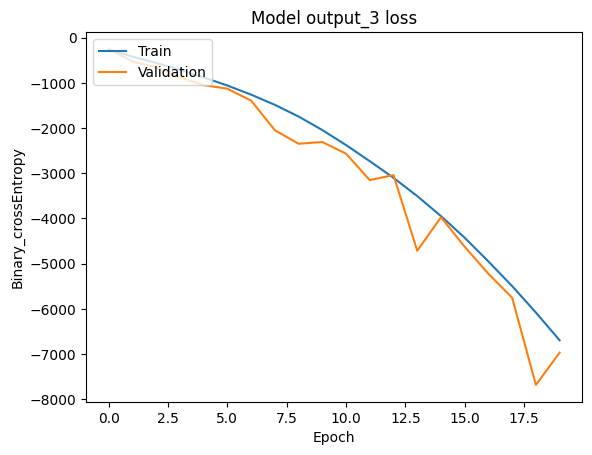

In [ ]:
plt.plot(history.history['output_3_loss'])
plt.plot(history.history['val_output_3_loss'])
plt.title('Model output_3 loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

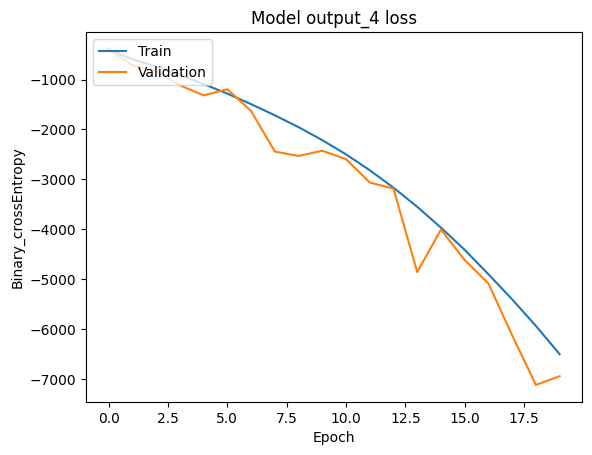

In [ ]:
plt.plot(history.history['output_4_loss'])
plt.plot(history.history['val_output_4_loss'])
plt.title('Model output_4 loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

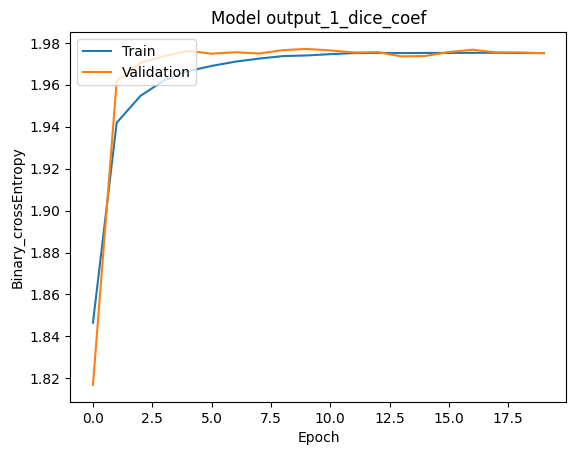

In [ ]:
plt.plot(history.history['output_1_dice_coef'])
plt.plot(history.history['val_output_1_dice_coef'])
plt.title('Model output_1_dice_coef')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

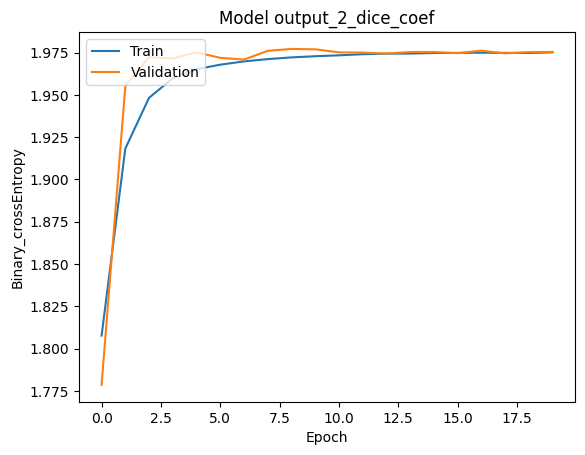

In [ ]:
plt.plot(history.history['output_2_dice_coef'])
plt.plot(history.history['val_output_2_dice_coef'])
plt.title('Model output_2_dice_coef')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

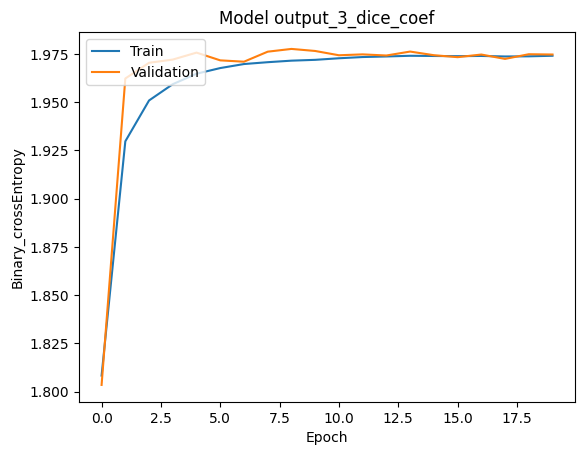

In [ ]:
plt.plot(history.history['output_3_dice_coef'])
plt.plot(history.history['val_output_3_dice_coef'])
plt.title('Model output_3_dice_coef')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

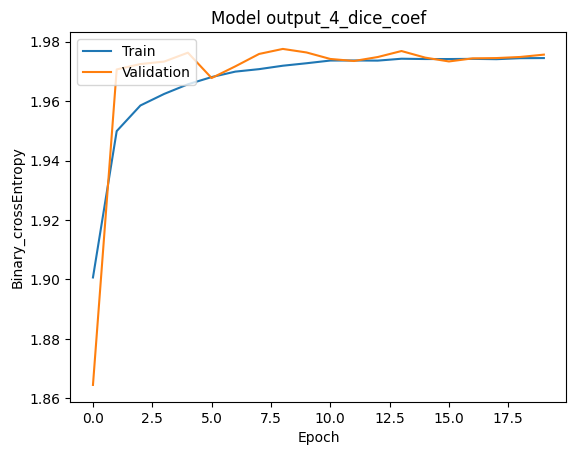

In [ ]:
plt.plot(history.history['output_4_dice_coef'])
plt.plot(history.history['val_output_4_dice_coef'])
plt.title('Model output_4_dice_coef')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

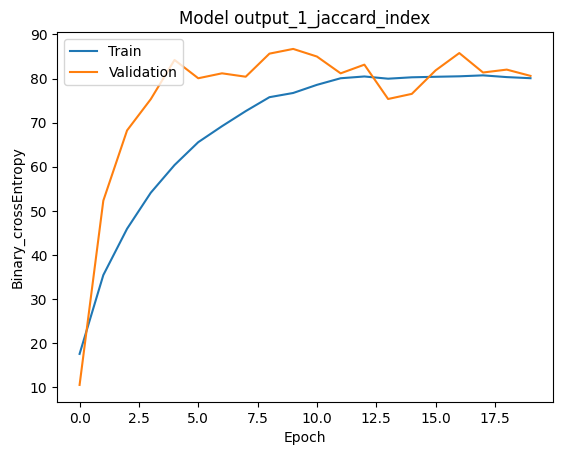

In [ ]:
plt.plot(history.history['output_1_jaccard_index'])
plt.plot(history.history['val_output_1_jaccard_index'])
plt.title('Model output_1_jaccard_index')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

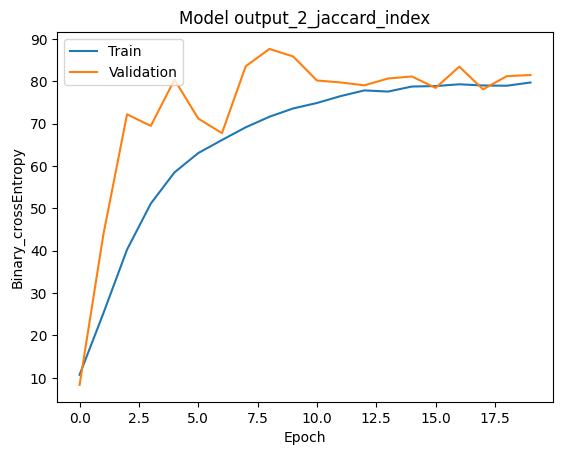

In [ ]:
plt.plot(history.history['output_2_jaccard_index'])
plt.plot(history.history['val_output_2_jaccard_index'])
plt.title('Model output_2_jaccard_index')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

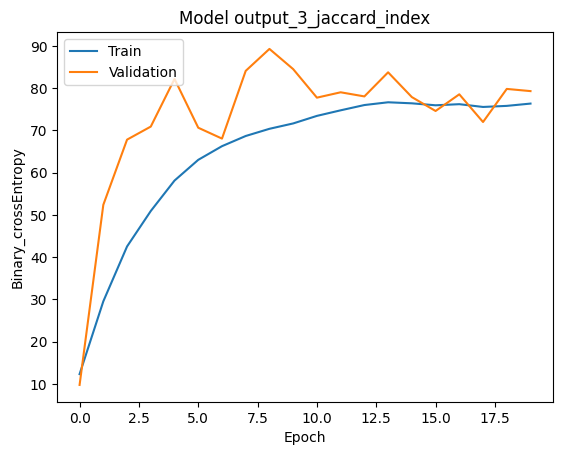

In [ ]:
plt.plot(history.history['output_3_jaccard_index'])
plt.plot(history.history['val_output_3_jaccard_index'])
plt.title('Model output_3_jaccard_index')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

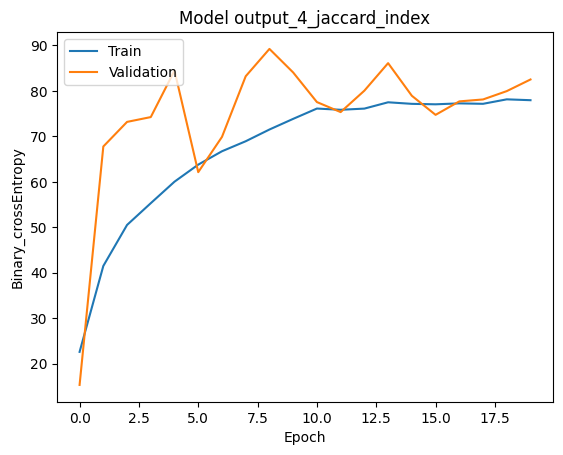

In [ ]:
plt.plot(history.history['output_4_jaccard_index'])
plt.plot(history.history['val_output_4_jaccard_index'])
plt.title('Model output_4_jaccard_index')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Make predictions
test_preds1, test_preds2, test_preds3, test_preds4 = model.predict(X_test)

# Print details about predictions
print(test_preds1.shape)
print(type(test_preds1))
print(test_preds1.dtype)
print('-' * 30)

print(test_preds2.shape)
print(type(test_preds2))
print(test_preds2.dtype)
print('-' * 30)

print(test_preds3.shape)
print(type(test_preds3))
print(test_preds3.dtype)
print('-' * 30)

print(test_preds4.shape)
print(type(test_preds4))
print(test_preds4.dtype)
print('-' * 30)

# Average the predictions
avg_output = tf.keras.layers.Average()([test_preds1, test_preds2, test_preds3, test_preds4])
avg_output = tf.keras.backend.eval(avg_output)

# Print details about the averaged output
print(avg_output.shape)
print(type(avg_output))
print(avg_output.dtype)
print('-' * 30)


(266, 128, 128, 3)
<class 'numpy.ndarray'>
float32
------------------------------
(266, 128, 128, 3)
<class 'numpy.ndarray'>
float32
------------------------------
(266, 128, 128, 3)
<class 'numpy.ndarray'>
float32
------------------------------
(266, 128, 128, 3)
<class 'numpy.ndarray'>
float32
------------------------------
(266, 128, 128, 3)
<class 'numpy.ndarray'>
float32
------------------------------


<class 'numpy.ndarray'>
(266, 128, 128, 3)
float32


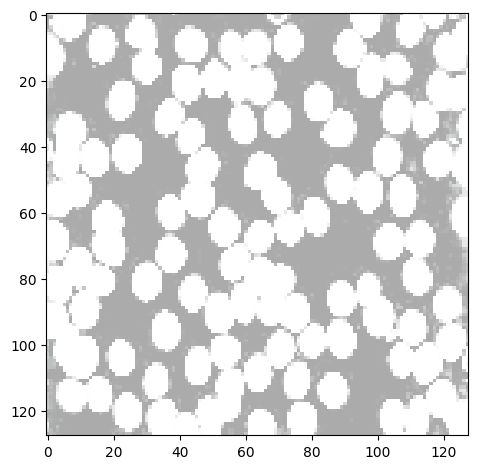

In [ ]:
print(type(avg_output))
print(avg_output.shape)
print(avg_output.dtype)
imshow(avg_output[0])

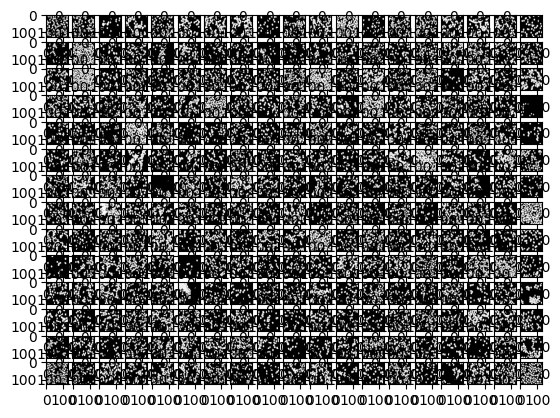

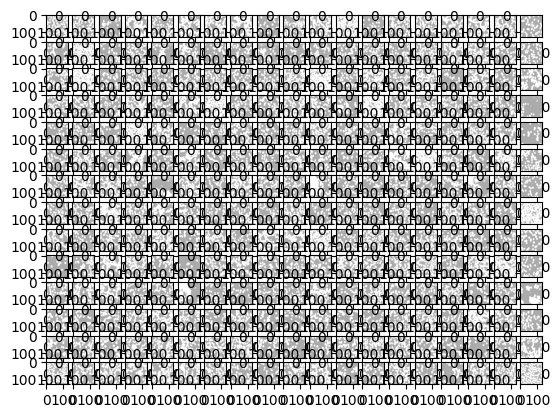

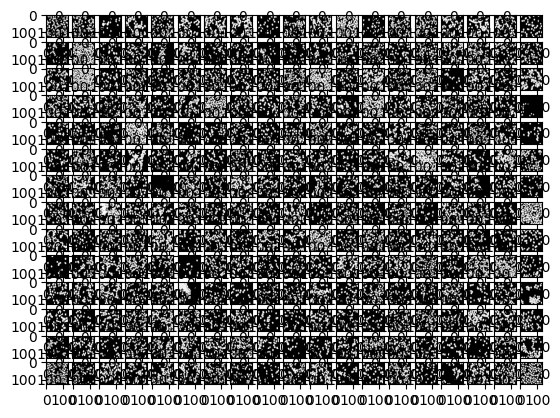

In [ ]:
from skimage.io import imshow_collection
imshow_collection(avg_output)
imshow_collection(y_test)

In [ ]:
#Evaluating Individual Dice-Co efficient
#Metrics for individual evaluation

def dice_coef2(a, b):
    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

uint8
float32
Dice Co-efficient:  Tensor("truediv_5:0", shape=(), dtype=float32)
Jaccard-index:  Tensor("truediv_7:0", shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


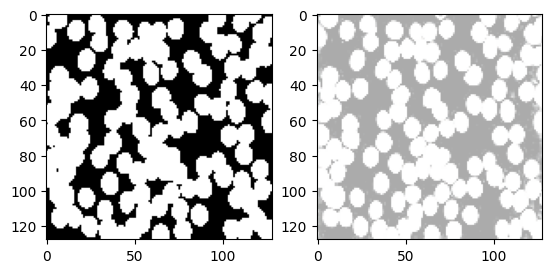

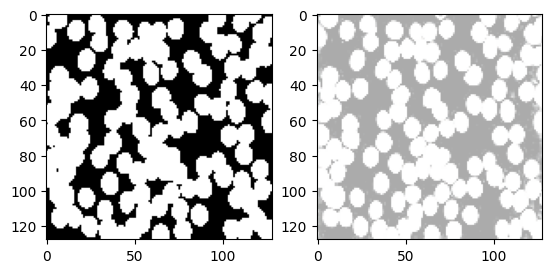

In [ ]:
import numpy as np
import tensorflow as tf
from skimage.io import imshow_collection

# correct data type for y_test and avg_output
print(y_test[0].dtype)  # Expected to be uint8
print(avg_output[0].dtype)  # Expected to be float32

# Convert both to the same dtype
i = tf.cast(y_test[0], dtype=tf.float32)
j = tf.cast(avg_output[0], dtype=tf.float32)

# Calculate Dice Coefficient
result = dice_coef2(i, j)
print('Dice Co-efficient: ', result)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
print('Jaccard-index: ', result2)

# same shape for both images
if i.shape != j.shape:
    j = tf.image.resize(j, i.shape[:2])  # Resize j to match i

# Convert Tensor to NumPy array
with tf.compat.v1.Session() as sess:
    i_np = i.eval(session=sess)
    j_np = j.eval(session=sess)

# Prepare for displaying
x = np.zeros((2, i_np.shape[0], i_np.shape[1], 3))  # Assuming 3 channels (RGB)
x[0] = i_np
x[1] = j_np

# Display the collection of images
imshow_collection(x)


uint8
float32
Dice Co-efficient:  Tensor("truediv_9:0", shape=(), dtype=float32)
Jaccard-index:  Tensor("truediv_11:0", shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


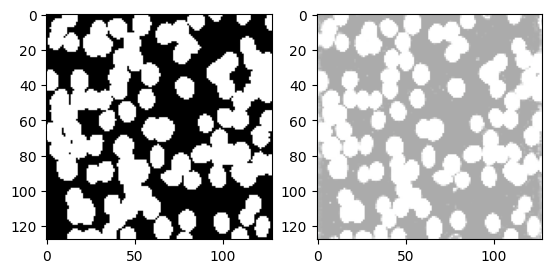

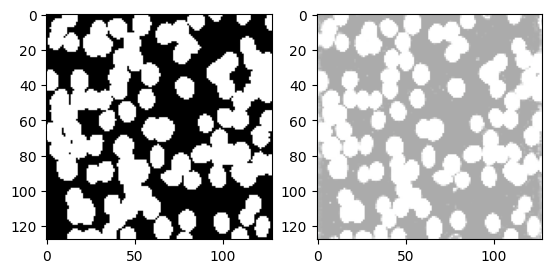

In [ ]:
import numpy as np
import tensorflow as tf
from skimage.io import imshow_collection

# correct data type for y_test[1] and avg_output[1]
print(y_test[1].dtype)  # Expected to be uint8
print(avg_output[1].dtype)  # Expected to be float32

# Convert both to the same dtype
i = tf.cast(y_test[1], dtype=tf.float32)
j = tf.cast(avg_output[1], dtype=tf.float32)

# Calculate Dice Coefficient
result = dice_coef2(i, j)
print('Dice Co-efficient: ', result)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
print('Jaccard-index: ', result2)

#  same shape
if i.shape != j.shape:
    j = tf.image.resize(j, i.shape[:2])  # Resize j to match i

# Convert Tensor to NumPy array
with tf.compat.v1.Session() as sess:
    i_np = i.eval(session=sess)
    j_np = j.eval(session=sess)

# Prepare for displaying
x = np.zeros((2, i_np.shape[0], i_np.shape[1], 3))
x[0] = i_np
x[1] = j_np

# Display the collection of images
imshow_collection(x)


Dice Co-efficient:  0.27977663
Jaccard-index:  0.16263984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


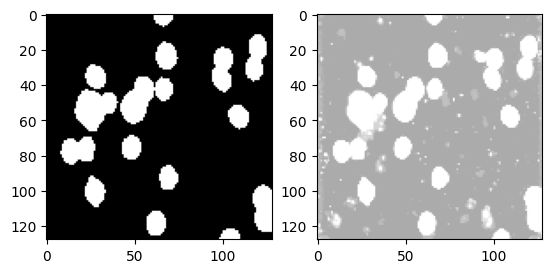

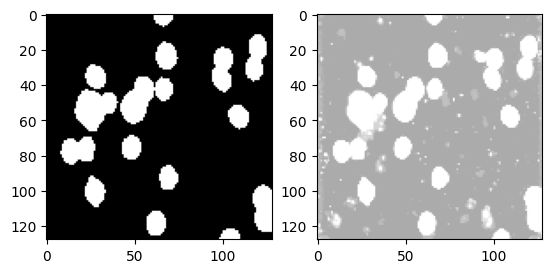

In [ ]:
import tensorflow as tf
import numpy as np

# ensuring types are the same
i = tf.cast(y_test[2], dtype=tf.float32)
j = avg_output[2]

# Calculate Dice Coefficient
result = dice_coef2(i, j)
dice_value = tf.keras.backend.get_value(result)
print('Dice Co-efficient: ', dice_value)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
jaccard_value = tf.keras.backend.get_value(result2)
print('Jaccard-index: ', jaccard_value)

# Prepare the arrays for display
x = np.zeros((2, i.shape[0], i.shape[1], 3), dtype=np.float32)

# Convert tensors to numpy for visualization
x[0] = tf.keras.backend.get_value(i)
x[1] = tf.keras.backend.get_value(j)


imshow_collection(x)


Dice Co-efficient:  0.56784505
Jaccard-index:  0.39649746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


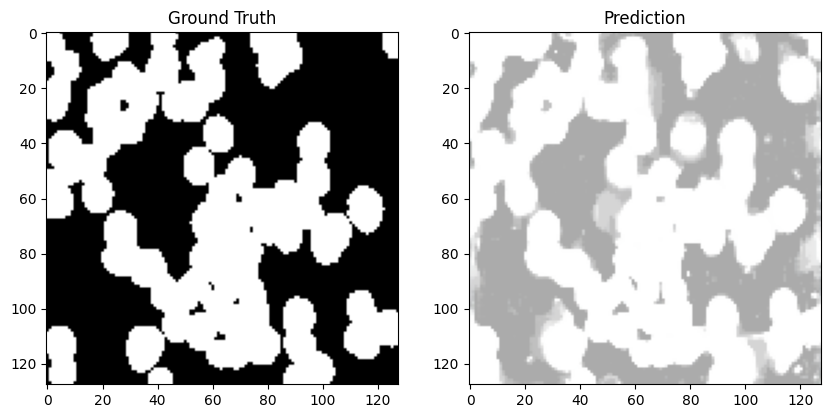

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#types are compatible by casting
i = tf.cast(y_test[3], dtype=tf.float32)
j = avg_output[3]

# Calculate Dice Coefficient
result = dice_coef2(i, j)
dice_value = tf.keras.backend.get_value(result)
print('Dice Co-efficient: ', dice_value)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
jaccard_value = tf.keras.backend.get_value(result2)
print('Jaccard-index: ', jaccard_value)

# Prepare the arrays for display
x = np.zeros((2, i.shape[0], i.shape[1], 3), dtype=np.float32)

# Convert tensors to NumPy arrays for visualization
x[0] = tf.keras.backend.get_value(i)  # Ground truth
x[1] = tf.keras.backend.get_value(j)  # Prediction

# Visualize using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(x[0])

plt.subplot(1, 2, 2)
plt.title('Prediction')
plt.imshow(x[1])

plt.show()


Dice Co-efficient:  0.55080426
Jaccard-index:  0.38007614


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


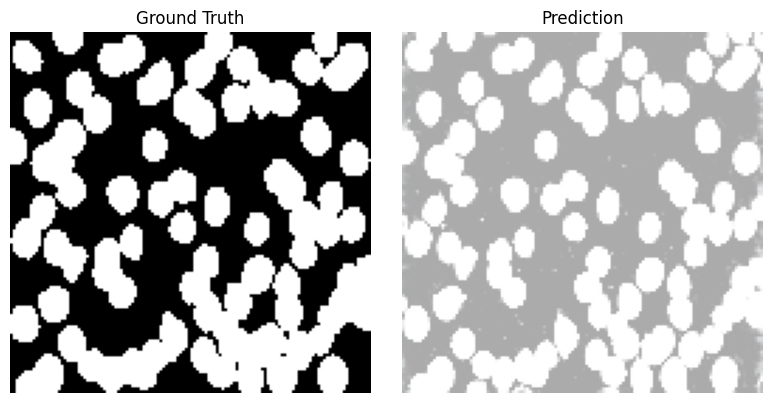

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# Ensure the types are consistent
i = tf.cast(y_test[4], dtype=tf.float32)
j = avg_output[4]

# Calculate Dice Coefficient
result = dice_coef2(i, j)
dice_value = tf.keras.backend.get_value(result)
print('Dice Co-efficient: ', dice_value)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
jaccard_value = tf.keras.backend.get_value(result2)
print('Jaccard-index: ', jaccard_value)

# Prepare the arrays for display
x = np.zeros((2, i.shape[0], i.shape[1], 3), dtype=np.float32)

# Convert tensors to numpy for visualization
x[0] = tf.keras.backend.get_value(i)  # Ground truth
x[1] = tf.keras.backend.get_value(j)  # Prediction

# Visualization function
def imshow_collection(images):
    """Display a collection of images."""
    plt.figure(figsize=(8, 4))  # Set the figure size
    plt.subplot(1, 2, 1)
    plt.imshow(images[0])  # Ground Truth
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(images[1])  # Prediction
    plt.title('Prediction')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
imshow_collection(x)


In [ ]:
import tensorflow as tf
import numpy as np

# Initialize average values for Dice and Jaccard
avg_dice = 0
avg_jaccard = 0

# Loop through test data and predictions
for x in range(len(avg_output)):
    i = tf.cast(y_test[x], dtype=tf.float32)
    j = avg_output[x]

    dice = dice_coef2(i, j)
    jaccard = jaccard_index2(i, j)

    avg_dice += tf.keras.backend.get_value(dice)
    avg_jaccard += tf.keras.backend.get_value(jaccard)

# Calculate averages
avg_dice /= len(avg_output)
avg_jaccard /= len(avg_output)

# Output the results
print('Average Test Dice Co-efficient: ', avg_dice)
print('Average Test Jaccard Index: ', avg_jaccard)


Average Test Dice Co-efficient:  0.5058923588043317
Average Test Jaccard Index:  0.34698538858919664


In [ ]:
history

In [ ]:
#Highest & Lowest

print('Lowest training loss: ',   min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))

print('Lowest training output_1_loss: ',       min(history.history['output_1_loss']))
print('Lowest validation val_output_1_loss: ', min(history.history['val_output_1_loss']))

print('Lowest training output_2_loss: ',       min(history.history['output_2_loss']))
print('Lowest validation val_output_1_loss: ', min(history.history['val_output_1_loss']))

print('Lowest training output_3_loss: ',       min(history.history['output_3_loss']))
print('Lowest validation val_output_3_loss: ', min(history.history['val_output_3_loss']))

print('Lowest training output_4_loss: ',       min(history.history['output_4_loss']))
print('Lowest validation val_output_4_loss: ', min(history.history['val_output_4_loss']))

print('Lowest training output_1_dice_coef: ',           max(history.history['output_1_dice_coef']))
print('Lowest validation val_output_1_dice_coef: ',     max(history.history['val_output_1_dice_coef']))
#output_1_dice_coef
print('Lowest training output_2_dice_coef: ',           max(history.history['output_2_dice_coef']))
print('Lowest validation val_output_2_dice_coef: ',     max(history.history['val_output_2_dice_coef']))

print('Lowest training output_3_dice_coef: ',           max(history.history['output_3_dice_coef']))
print('Lowest validation val_output_3_dice_coef: ',     max(history.history['val_output_3_dice_coef']))

print('Lowest training output_4_dice_coef: ',           max(history.history['output_4_dice_coef']))
print('Lowest validation val_output_4_dice_coef: ',     max(history.history['val_output_4_dice_coef']))

print('Lowest training output_1_jaccard_index: ',           max(history.history['output_1_jaccard_index']))
print('Lowest validation val_output_1_jaccard_index: ',     max(history.history['val_output_1_jaccard_index']))

print('Lowest training output_2_jaccard_index: ',           max(history.history['output_2_jaccard_index']))
print('Lowest validation val_output_2_jaccard_index: ',     max(history.history['val_output_2_jaccard_index']))

print('Lowest training output_3_jaccard_index: ',           max(history.history['output_3_jaccard_index']))
print('Lowest validation val_output_3_jaccard_index: ',     max(history.history['val_output_3_jaccard_index']))

print('Lowest training output_4_jaccard_index: ',           max(history.history['output_4_jaccard_index']))
print('Lowest validation val_output_4_jaccard_index: ',     max(history.history['val_output_4_jaccard_index']))


Lowest training loss:  -26367.48692735602
Lowest validation loss:  -28394.510769567758
Lowest training output_1_loss:  -6498.2056
Lowest validation val_output_1_loss:  -6565.085
Lowest training output_2_loss:  -6672.5015
Lowest validation val_output_1_loss:  -6565.085
Lowest training output_3_loss:  -6695.4604
Lowest validation val_output_3_loss:  -7683.1523
Lowest training output_4_loss:  -6501.116
Lowest validation val_output_4_loss:  -7116.8506
Lowest training output_1_dice_coef:  1.9752579
Lowest validation val_output_1_dice_coef:  1.9771032
Lowest training output_2_dice_coef:  1.9750634
Lowest validation val_output_2_dice_coef:  1.9771162
Lowest training output_3_dice_coef:  1.9740283
Lowest validation val_output_3_dice_coef:  1.9775736
Lowest training output_4_dice_coef:  1.9744948
Lowest validation val_output_4_dice_coef:  1.9775718
Lowest training output_1_jaccard_index:  80.723145
Lowest validation val_output_1_jaccard_index:  86.721855
Lowest training output_2_jaccard_index: 